In [1]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 指定文件夹路径
# download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
# download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
# download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [2]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

# 查找给定变量名称对应的总序数
def find_var_idx(var_name, var_dict):
    count = 0
    for var_list in var_dict.values():
        if var_name in var_list:
            count += var_list.index(var_name)
            return(count)
        else:
            count += len(var_list)

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


In [9]:
from sklearn.preprocessing import StandardScaler

def dataSampling(var_data, var_rate, wshr_data):
    # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
    if var_rate == 1:
        sampling_data = var_data
    else: # 进行重采样
        sampling_data = [var_data[i] for i in np.linspace(0, len(var_data)- 1, len(wshr_data), dtype=int)]
    # # 将采样数据进行min_max归一化
    # if (np.max(sampling_data) - np.min(sampling_data)) > 1e-5:
    #     sampling_data = (sampling_data - np.min(sampling_data)) / (np.max(sampling_data) - np.min(sampling_data))
    # else:
    #     sampling_data = sampling_data
    return sampling_data

def dataConstruct(work_folder_path, work_mat_name, variable_list, is_all_variable = False):
    # 读取工作mat
    work_mat = loadmat(os.path.join(work_folder_path, work_mat_name))

    # 初始化采样数据list
    sampling_data_list = []
    wshr_data = work_mat["WSHR"][0][0][0]

    if not is_all_variable:
        # 提取variable_list变量并进行重采样
        for var_name in variable_list:
            var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
            sampling_data = dataSampling(var_data, var_rate, wshr_data)
            # print(np.max(sampling_data), np.min(sampling_data))
            sampling_data_list.append(sampling_data)
    else:
        for var_list in var_groups_dict.values():
            for var_name in var_list:
                var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
                sampling_data = dataSampling(var_data, var_rate, wshr_data)
                # print(np.max(sampling_data), np.min(sampling_data))
                sampling_data_list.append(sampling_data)
        sampling_data_list = np.squeeze(np.array(sampling_data_list))

    # 生成解释变量X和分类变量Y
    X = np.squeeze(np.array(sampling_data_list)).T
    Y = np.array(wshr_data).reshape(-1,1)
    # # 数据标准化
    # s_scaler = StandardScaler()
    # X = s_scaler.fit_transform(X)

    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    # print(X.shape, Y.shape)
    print(f"Wind Shear Warns at time {wshr_class_idx[0]}")

    # if not is_all_variable:
    #     # 绘制X的时间变化
    #     plt.figure()
    #     for i, var_name in enumerate(variable_list):
    #         plt.plot(range(len(wshr_data)), X[:, i], label=var_name)
    #     plt.plot(range(len(wshr_data)), Y, c='red', label='Wind Shear Warning')
    #     plt.xlabel('time(s)')
    #     plt.ylabel('WS/WD/TAS & WSHR')
    #     plt.title('Normalized WS/WD/TAS and WSHR')
    #     plt.legend()
    #     # if np.std(X[:, 2]) > 1e-1:
    #     #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
    #     plt.show()

    #     # 绘制X的三维散点图
    #     fig = plt.figure(figsize=(5, 5))
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
    #     ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
    #     ax.set_xlabel(variable_list[0])
    #     ax.set_ylabel(variable_list[1])
    #     ax.set_zlabel(variable_list[2])
    #     ax.legend()
    #     plt.tight_layout()
    #     plt.show()

    return X, Y

Wind Shear Warns at time [938 939 940 941 942 943]


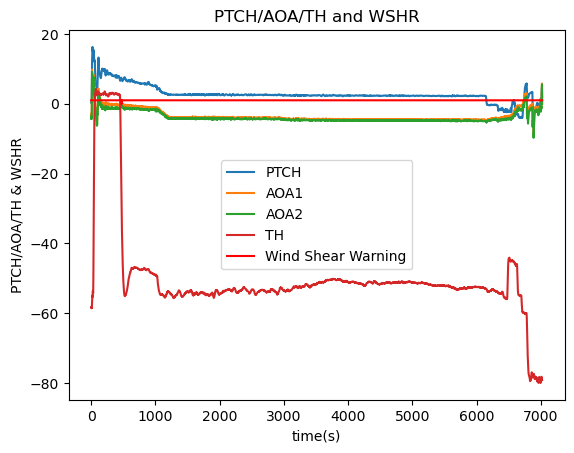

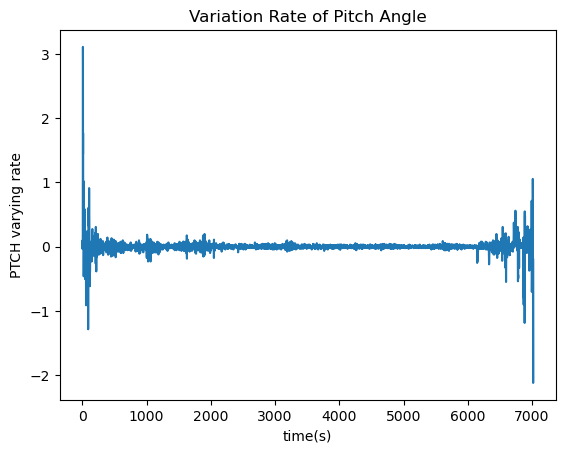

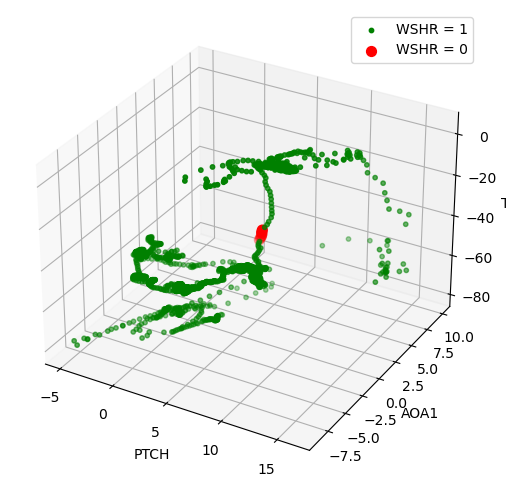

In [24]:
# 判据三：俯仰姿态(PTCH) = 迎角(AOA) + 轨迹角(TH)，变化率不超过5度
variable_list = ['PTCH', 'AOA1', 'AOA2', 'TH']
'''
AOA1和AOA2能否做平均？TH和AOA如何生成PTCH？
'''

# 构建数据集
X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list)
# 读取聚类标签
cluster_labels = np.load('../result/variable_clustering/DBSCAN/cluster_labels_e[3][2].npy')
# 抽取训练集中的有效数据
X, Y = X[cluster_labels == 2-1], Y[cluster_labels == 2-1]

PTCH_diff = X[1:, 0] - X[:-1, 0]

# 绘制X的时间变化
plt.figure()
for i, var_name in enumerate(variable_list):
    plt.plot(range(len(Y)), X[:, i], label=var_name)
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
plt.xlabel('time(s)')
plt.ylabel('PTCH/AOA/TH & WSHR')
plt.title('PTCH/AOA/TH and WSHR')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 绘制俯仰姿态的时序差分图
plt.figure()
plt.plot(range(len(PTCH_diff)), PTCH_diff)
plt.title('Variation Rate of Pitch Angle')
plt.xlabel('time(s)')
plt.ylabel('PTCH varying rate')
plt.show()

# 绘制X的三维散点图
wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 3], c='green', s = 10, label='WSHR = 1')
ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 3], c='red', s = 50, label='WSHR = 0')
ax.set_xlabel(variable_list[0])
ax.set_ylabel(variable_list[1])
ax.set_zlabel(variable_list[3])
ax.legend()
plt.tight_layout()
plt.show()


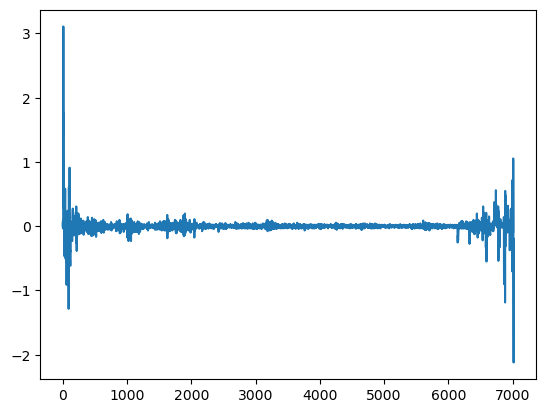

In [20]:
# 判据一：指示空速变化率不超过15节

In [ ]:
# 判据二：垂直升降率不超过500英尺/分钟